<a href="https://colab.research.google.com/github/Ad0420/Wildfires/blob/main/Copy_of_Copy_of_CAIS%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%cd

/root


In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import preprocessing

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soniazhang04","key":"03663cd02c2feeb8028b8f1326384838"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Get data

In [ ]:
!kaggle datasets download -d fantineh/next-day-wildfire-spread

100% 2.08G/2.08G [01:17<00:00, 37.6MB/s]
100% 2.08G/2.08G [01:17<00:00, 28.8MB/s]


In [ ]:
!unzip next-day-wildfire-spread.zip

Archive:  next-day-wildfire-spread.zip
  inflating: next_day_wildfire_spread_eval_00.tfrecord  
  inflating: next_day_wildfire_spread_eval_01.tfrecord  
  inflating: next_day_wildfire_spread_test_00.tfrecord  
  inflating: next_day_wildfire_spread_test_01.tfrecord  
  inflating: next_day_wildfire_spread_train_00.tfrecord  
  inflating: next_day_wildfire_spread_train_01.tfrecord  
  inflating: next_day_wildfire_spread_train_02.tfrecord  
  inflating: next_day_wildfire_spread_train_03.tfrecord  
  inflating: next_day_wildfire_spread_train_04.tfrecord  
  inflating: next_day_wildfire_spread_train_05.tfrecord  
  inflating: next_day_wildfire_spread_train_06.tfrecord  
  inflating: next_day_wildfire_spread_train_07.tfrecord  
  inflating: next_day_wildfire_spread_train_08.tfrecord  
  inflating: next_day_wildfire_spread_train_09.tfrecord  
  inflating: next_day_wildfire_spread_train_10.tfrecord  
  inflating: next_day_wildfire_spread_train_11.tfrecord  
  inflating: next_day_wildfire_spread

Extract features

In [ ]:
import tensorflow as tf

def list_record_features(tfrecords_path):
    # Dict of extracted feature information
    features = {}
    # Iterate records
    for rec in tf.data.TFRecordDataset([str(tfrecords_path)]):
        # Get record bytes
        example_bytes = rec.numpy()
        # Parse example protobuf message
        example = tf.train.Example()
        example.ParseFromString(example_bytes)
        # Iterate example features
        for key, value in example.features.feature.items():
            # Kind of data in the feature
            kind = value.WhichOneof('kind')
            # Size of data in the feature
            size = len(getattr(value, kind).value)
            # Check if feature was seen before
            if key in features:
                # Check if values match, use None otherwise
                kind2, size2 = features[key]
                if kind != kind2:
                    kind = None
                if size != size2:
                    size = None
            # Save feature data
            features[key] = (kind, size)
    return features

tfrecords_path = '/content/next_day_wildfire_spread_eval_00.tfrecord'
features = list_record_features(tfrecords_path)
print(*features.items(), sep='\n')
# ('id', ('int64_list', 1))
# ('data', ('float_list', None))

Parse data

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [ ]:
from numpy import extract
def parse_tfr_element(event):

  #define the dictionary -- the structure -- of our single example
  data = {
        'elevation' : tf.io.FixedLenFeature([4096], tf.float32),
        'th' : tf.io.FixedLenFeature([4096], tf.float32),
        'vs' : tf.io.FixedLenFeature([4096], tf.float32),
        'tmmn' : tf.io.FixedLenFeature([4096], tf.float32),
        'tmmx' : tf.io.FixedLenFeature([4096], tf.float32),
        'sph' : tf.io.FixedLenFeature([4096], tf.float32),
        'pr' : tf.io.FixedLenFeature([4096], tf.float32),
        'pdsi' : tf.io.FixedLenFeature([4096], tf.float32),
        'NDVI' : tf.io.FixedLenFeature([4096], tf.float32),
        'population' : tf.io.FixedLenFeature([4096], tf.float32),
        'erc' : tf.io.FixedLenFeature([4096], tf.float32),
        'PrevFireMask' : tf.io.FixedLenFeature([4096], tf.float32),
        'FireMask' : tf.io.FixedLenFeature([4096], tf.float32),
    }
  #create an Example, wrapping the single features
  content = tf.io.parse_single_example(event, data)

  # elevation = tf.io.decode_raw(content['elevation'], tf.uint8)
  elevation = content['elevation']
  elevation = tf.cast(elevation, tf.float32) / 255.0
  elevation = np.reshape(elevation, (64,64))
  # th = tf.io.decode_raw(content['th'], tf.uint8)
  th = content['th']
  th = tf.cast(th, tf.float32) / 255.0
  th = np.reshape(th, (64,64))

  vs = content['vs']
  vs = tf.cast(vs, tf.float32) / 255.0
  vs = np.reshape(vs, (64,64))
  # tmmn = tf.io.decode_raw(content['tmmn'], tf.uint8)
  tmmn = content['tmmn']
  tmmn = tf.cast(tmmn, tf.float32) / 255.0
  tmmn = np.reshape(tmmn, (64,64))
  # tmmx = tf.io.decode_raw(content['tmmx'], tf.uint8)
  tmmx = content['tmmx']
  tmmx = tf.cast(tmmx, tf.float32) / 255.0
  tmmx = np.reshape(tmmx, (64,64))
  # sph = tf.io.decode_raw(content['sph'], tf.uint8)
  sph = content['sph']
  sph = tf.cast(sph, tf.float32) / 255.0
  sph = np.reshape(sph, (64,64))
  # pr = tf.io.decode_raw(content['pr'], tf.uint8)
  pr = content['pr']
  pr = tf.cast(pr, tf.float32) / 255.0
  pr = np.reshape(pr, (64,64))
  # pdsi = tf.io.decode_raw(content['pdsi'], tf.uint8)
  pdsi = content['pdsi']
  pdsi = tf.cast(pdsi, tf.float32) / 255.0
  pdsi = np.reshape(pdsi, (64,64))
  # NDVI = tf.io.decode_raw(content['NDVI'], tf.uint8)
  NDVI = content['NDVI']
  NDVI = tf.cast(NDVI, tf.float32) / 255.0
  NDVI = np.reshape(NDVI, (64,64))
  # population = tf.io.decode_raw(content['population'], tf.uint8)
  population = content['population']
  population = tf.cast(population, tf.float32) / 255.0
  population = np.reshape(population, (64,64))
  # erc = tf.io.decode_raw(content['erc'], tf.uint8)
  erc = content['erc']
  erc = tf.cast(erc, tf.float32) / 255.0
  erc = np.reshape(erc, (64,64))
  # PrevFireMask = tf.io.decode_raw(content['erc'], tf.uint8)
  PrevFireMask = content['PrevFireMask']
  PrevFireMask = tf.cast(PrevFireMask, tf.float32) / 255.0
  PrevFireMask = np.reshape(PrevFireMask, (64,64))
  FireMask = content['FireMask']
  FireMask = tf.cast(FireMask, tf.float32) / 255.0
  FireMask = np.reshape(FireMask, (64,64))

  return elevation, th, vs, tmmn, tmmx, sph, pr, pdsi, NDVI, population, erc, PrevFireMask, FireMask

# parsed_dataset = raw_dataset.map(parse_tfr_element)

In [ ]:
print(parsed_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None), TensorSpec(shape=(4096,), dtype=tf.float32, name=None))>


In [ ]:
train_data = pd.DataFrame(columns=['elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask'])

tfrecord_filename = '/content/next_day_wildfire_spread_train_0{}.tfrecord'
tfrecord_filename1 = '/content/next_day_wildfire_spread_train_{}.tfrecord'

for index in range(10): # Number of splits
    # if not (index == 0):
      writer = tf.data.TFRecordDataset(tfrecord_filename.format(index))

      temp_data = writer.map(parse_tfr_element)
      temp_df = pd.DataFrame(
          temp_data.as_numpy_iterator(),
          columns=['elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']
      )
      train_data = train_data.append(temp_df, ignore_index=True)


for index in range(10,15): # Number of splits
    # if not (index == 0):
      writer = tf.data.TFRecordDataset(tfrecord_filename1.format(index))

      temp_data = writer.map(parse_tfr_element)
      temp_df = pd.DataFrame(
          temp_data.as_numpy_iterator(),
          columns=['elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']
      )
      train_data = train_data.append(temp_df, ignore_index=True)

print(train_data.shape)


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
<ipython-input-14-c91ac7290ede>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(temp_df, ignore_index=True)
/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
<ipython-input-14-c91ac7290ede>:15: FutureWarning: The frame.app

(14979, 13)


<ipython-input-14-c91ac7290ede>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(temp_df, ignore_index=True)


In [ ]:
train_data.shape

(14979, 13)

In [ ]:
test_data = pd.DataFrame(columns=['elevation', 'th', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask'])

tfrecord_filename = '/content/next_day_wildfire_spread_test_0{}.tfrecord'
file_index_count = 0

for index in range(2): # Number of splits
    # if not (index == 0):
      writer = tf.data.TFRecordDataset(tfrecord_filename.format(index))

      temp_data = writer.map(parse_tfr_element)
      temp_df = pd.DataFrame(
          temp_data.as_numpy_iterator(),
          columns=['elevation', 'th', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']
      )



      test_data = test_data.append(temp_df, ignore_index=True)

In [ ]:
eval_data = pd.DataFrame(columns=['elevation', 'th', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask'])

tfrecord_filename = '/content/next_day_wildfire_spread_eval_0{}.tfrecord'
file_index_count = 0

for index in range(2): # Number of splits
    # if not (index == 0):
      writer = tf.data.TFRecordDataset(tfrecord_filename.format(index))

      temp_data = writer.map(parse_tfr_element)
      temp_df = pd.DataFrame(
          temp_data.as_numpy_iterator(),
          columns=['elevation', 'th', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']
      )

      eval_data = eval_data.append(temp_df, ignore_index=True)

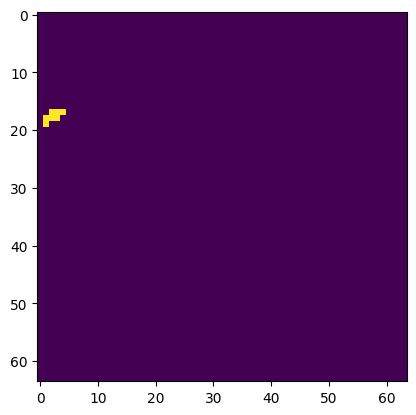

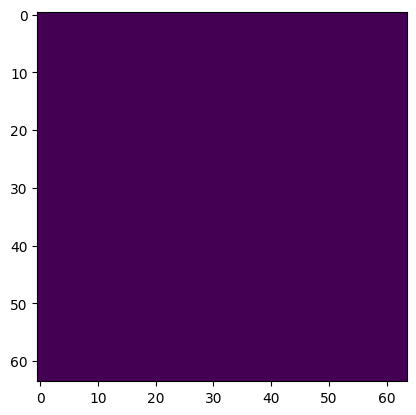

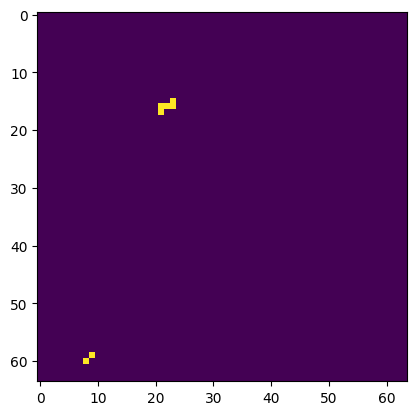

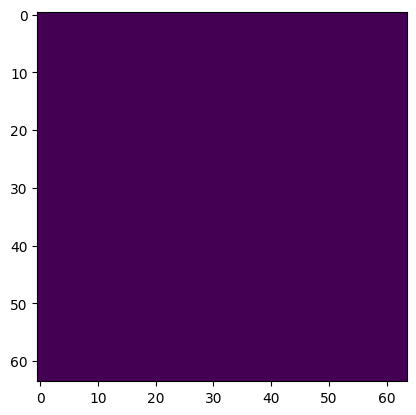

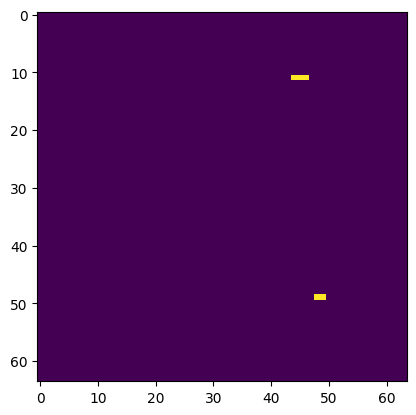

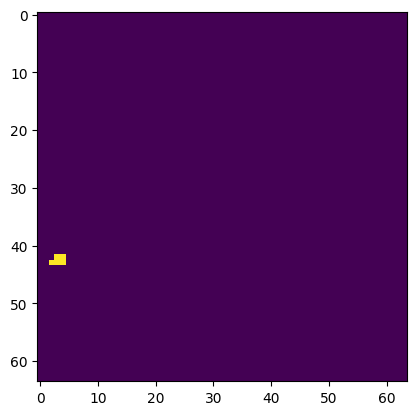

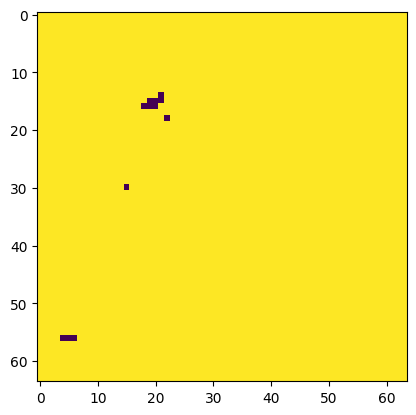

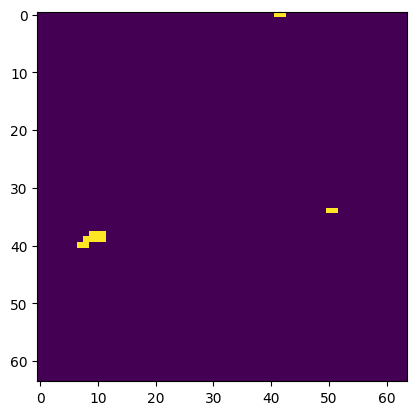

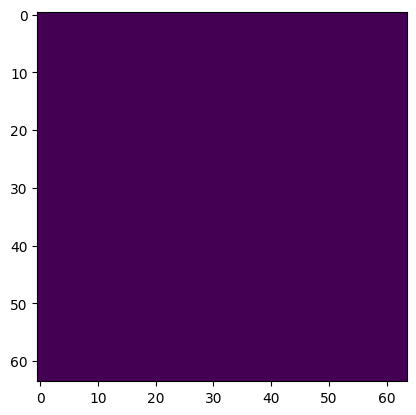

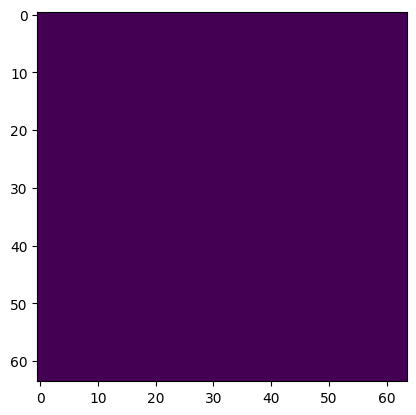

In [ ]:
view = train_data.loc[:, 'FireMask'].to_numpy()

for i in range(10):
  plt.subplots()
  plt.imshow(view[i])

In [ ]:
averages = [train_data.loc[:, 'elevation'].mean().mean(),
            train_data.loc[:, 'th'].mean().mean(),
            train_data.loc[:, 'vs'].mean().mean(),
            train_data.loc[:, 'tmmn'].mean().mean(),
            train_data.loc[:, 'tmmx'].mean().mean(),
            train_data.loc[:, 'sph'].mean().mean(),
            train_data.loc[:, 'pr'].mean().mean(),
            train_data.loc[:, 'pdsi'].mean().mean(),
            train_data.loc[:, 'NDVI'].mean().mean(),
            train_data.loc[:, 'population'].mean().mean(),
            train_data.loc[:, 'erc'].mean().mean(),
            train_data.loc[:, 'PrevFireMask'].mean().mean(),
            train_data.loc[:, 'FireMask'].mean().mean(),]

print(averages)

[3.5159016, 0.5750847, 0.014226857, 1.1053025, 1.1675161, 2.5593412e-05, 0.0012683462, -0.003030866, 20.983063, 0.11945215, 0.20968276, -1.0677875e-05, -5.0024435e-05]


In [ ]:
stds = [3.3043535,
        13.470818,
        0.0051341737,
        .07253783,
        0.076306224,
        1.464917e-05,
        0.0065634535,
        0.0092846025,
        8.331375,
        0.8399834,
        0.10080384,
        np.std(train_data.loc[:, 'PrevFireMask'].to_numpy(), ddof=1).mean(),
        np.std(train_data.loc[:, 'FireMask'].to_numpy(), ddof=1).mean(),]

print(stds)

[3.3043535, 13.470818, 0.0051341737, 0.07253783, 0.076306224, 1.464917e-05, 0.0065634535, 0.0092846025, 8.331375, 0.8399834, 0.10080384, 0.0005261419, 0.00069785793]


In [ ]:
elevation_data = train_data['pr'].to_numpy()
elevation_data = np.concatenate(elevation_data).ravel()

print(elevation_data.std())

0.006014379


Build model

In [ ]:
pip install tensorflow keras


In [ ]:
from tensorflow.python.keras import backend as K

def custom_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = K.cast(y_true, dtype=tf.float32)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy from probabilities.
        bce = y_true * tf.math.log(y_pred + epsilon)
        bce += (1 - y_true) * tf.math.log(1 - y_pred + epsilon)
        bce = -bce

        # Apply the weights to each class individually
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        # Return the mean error
        return tf.reduce_mean(weighted_bce)

    return weighted_binary_crossentropy

loss_function = custom_weighted_binary_crossentropy(0.51916421, 13.54515271)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

loss_function = dice_coef

In [ ]:
weights

array([ 0.51916421, 13.54515271])

In [ ]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 12

In [ ]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy',tf.keras.metrics.Recall()])


Compile Model

In [ ]:
from numpy import zeros, newaxis

# X_train = np.zeros((14979, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# Y_train = np.zeros((14979, IMG_HEIGHT, IMG_WIDTH, 1))
# for i, row in train_data.iterrows():
#   features = np.stack( (row['elevation'], row['th'], row['tmmn'], row['tmmx'], row['sph'], row['pr'], row['pdsi'], row['NDVI'], row['population'], row['erc'], row['PrevFireMask']), axis=2 )
#   X_train[i] = features
#   mask = row['FireMask'][:, :, newaxis]
#   Y_train[i] = mask

X_train = np.zeros((2000, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_train = np.zeros((2000, IMG_HEIGHT, IMG_WIDTH, 1))
for i, row in train_data.iterrows():
  if i==2000:
    break
  features = np.stack( (row['elevation'], row['th'], row['vs'], row['tmmn'], row['tmmx'], row['sph'], row['pr'], row['pdsi'], row['NDVI'], row['population'], row['erc'], row['PrevFireMask']), axis=2 )
  mask = row['FireMask'][:, :, newaxis]
  for index in range(11):
    features[:,:,index] = (features[:,:,index] - averages[index]) / stds[index]
  X_train[i] = features
  for j in range(64):
    for k in range(64):
      if mask[j][k] != 0:
        Y_train[i][j][k] = 1
      else:
        Y_train[i][j][k] = 0
      if X_train[i,j,k,11] != 0:
        X_train[i,j,k,11] = 1
      else:
        X_train[i,j,k,11] = 0

In [ ]:
X_train.shape

(2000, 64, 64, 12)

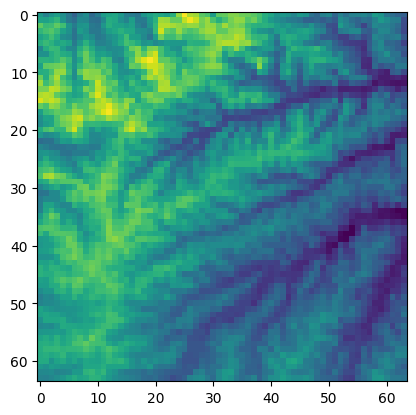

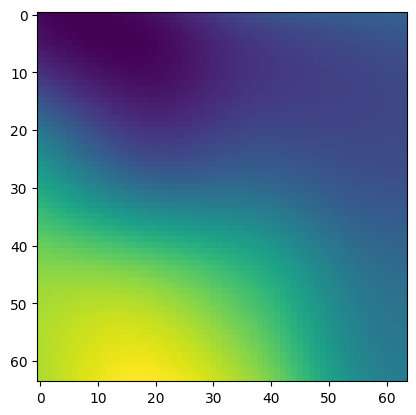

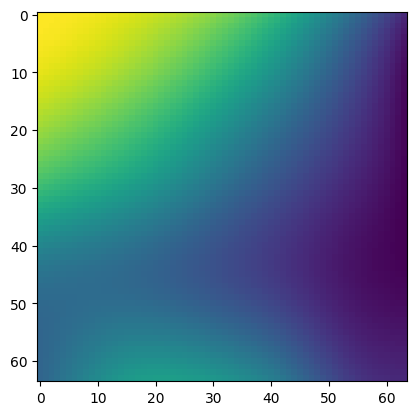

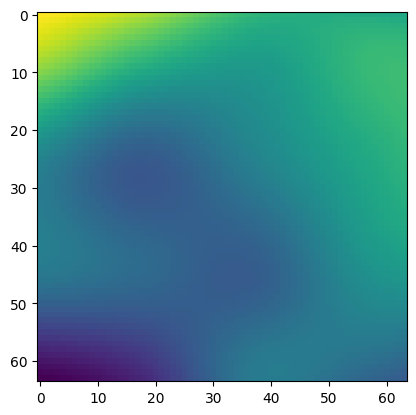

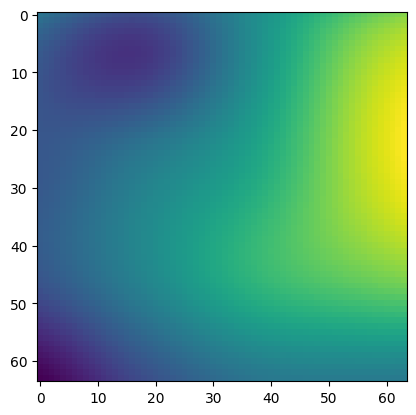

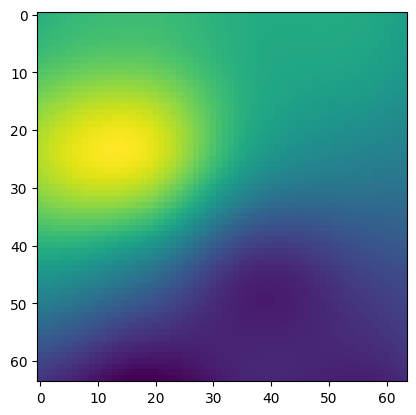

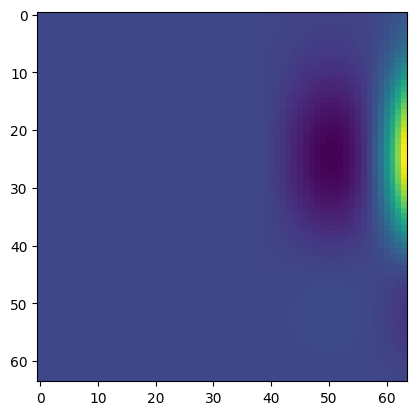

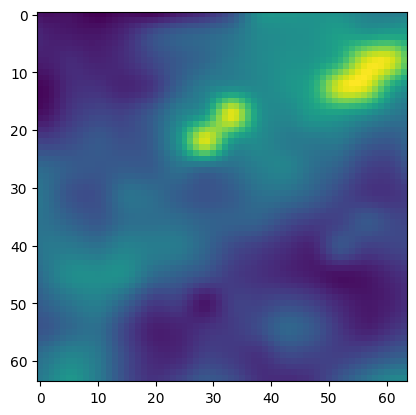

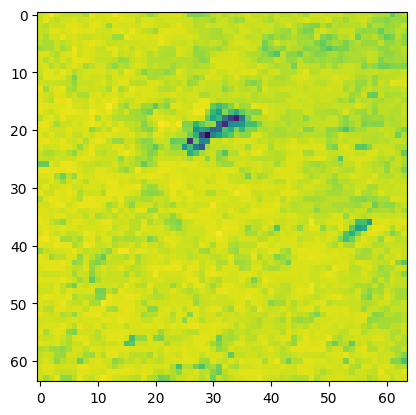

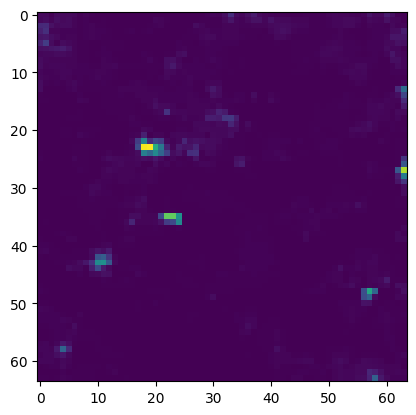

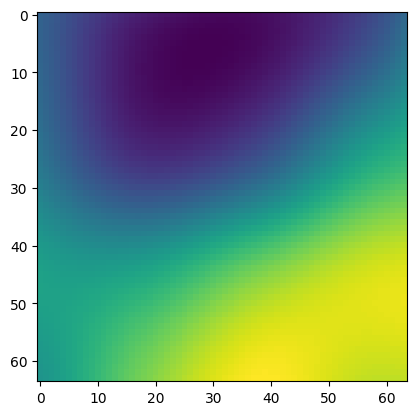

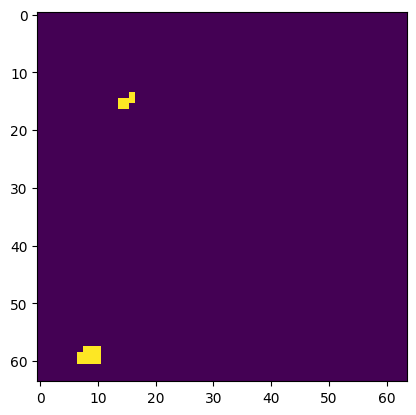

In [ ]:
for i in range(12):
  plt.subplots()
  plt.imshow(X_train[2,:,:,i])

In [ ]:
plt.imshow(Y_train[2])

In [ ]:
model = tf.keras.models.load_model('my_model', compile=False)

In [ ]:
model.summary()

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=25, callbacks=callbacks)

Epoch 1/25
57/57 [==============================] - 25s 432ms/step - loss: 0.7502 - accuracy: 0.7713 - recall_3: 0.2266 - val_loss: 0.5776 - val_accuracy: 0.6257 - val_recall_3: 0.4376
Epoch 2/25
57/57 [==============================] - 24s 426ms/step - loss: 0.7002 - accuracy: 0.5884 - recall_3: 0.5026 - val_loss: 0.5651 - val_accuracy: 0.8127 - val_recall_3: 0.2286
Epoch 3/25
57/57 [==============================] - 24s 418ms/step - loss: 0.6753 - accuracy: 0.6433 - recall_3: 0.5390 - val_loss: 0.5550 - val_accuracy: 0.7670 - val_recall_3: 0.3664
Epoch 4/25
57/57 [==============================] - 24s 418ms/step - loss: 0.6476 - accuracy: 0.6963 - recall_3: 0.5682 - val_loss: 0.5326 - val_accuracy: 0.7645 - val_recall_3: 0.4590
Epoch 5/25
57/57 [==============================] - 25s 432ms/step - loss: 0.6275 - accuracy: 0.7021 - recall_3: 0.6174 - val_loss: 0.5282 - val_accuracy: 0.7820 - val_recall_3: 0.4208
Epoch 6/25
57/57 [==============================] - 25s 434ms/step - loss: 

In [ ]:
results.history

{'loss': [0.7501665353775024,
  0.7001827955245972,
  0.6753455996513367,
  0.6475674510002136,
  0.6274958848953247,
  0.6166024208068848,
  0.6070422530174255,
  0.5905240774154663,
  0.5820559859275818,
  0.5748170018196106,
  0.563129723072052,
  0.5572717785835266,
  0.5418577790260315,
  0.5340018272399902,
  0.5370803475379944,
  0.5176036357879639,
  0.5092228055000305,
  0.5058868527412415,
  0.4861278533935547,
  0.47991302609443665,
  0.4642520844936371,
  0.4672159254550934,
  0.45118290185928345,
  0.44744744896888733],
 'accuracy': [0.7713271975517273,
  0.5884075164794922,
  0.6432855725288391,
  0.6962544918060303,
  0.7021188735961914,
  0.7172055244445801,
  0.6973464488983154,
  0.7064505815505981,
  0.7154816389083862,
  0.7305065989494324,
  0.7268084287643433,
  0.7200788259506226,
  0.7480971813201904,
  0.7435465455055237,
  0.7386369109153748,
  0.749097466468811,
  0.7482763528823853,
  0.759899914264679,
  0.767663300037384,
  0.7686280608177185,
  0.77868175

In [ ]:
model.save("my_model")

In [ ]:
y_pred = model.predict(X_train[:10])

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 743ms/step


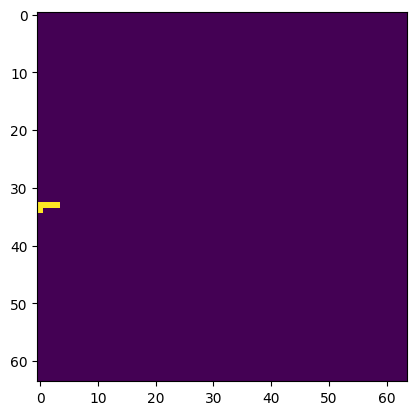

In [ ]:
plt.imshow(X_train[1,:,:,11])

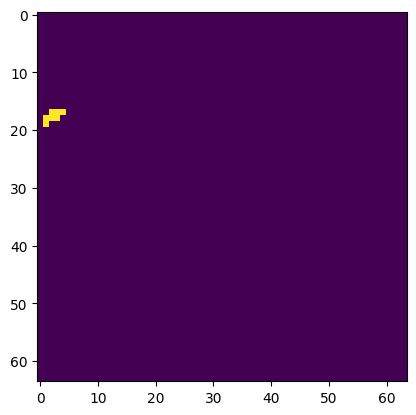

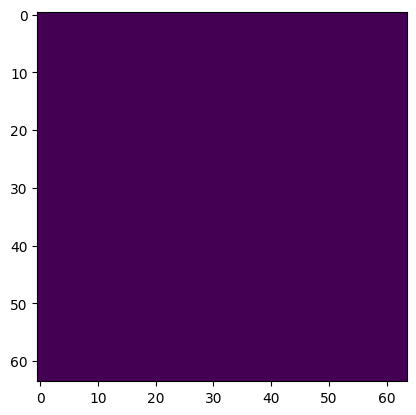

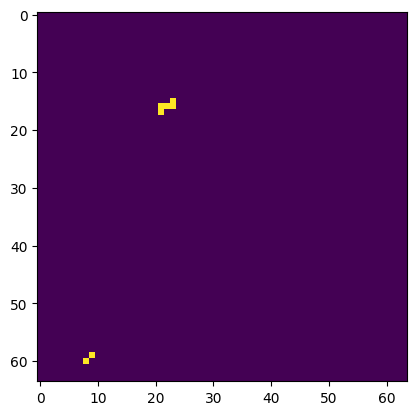

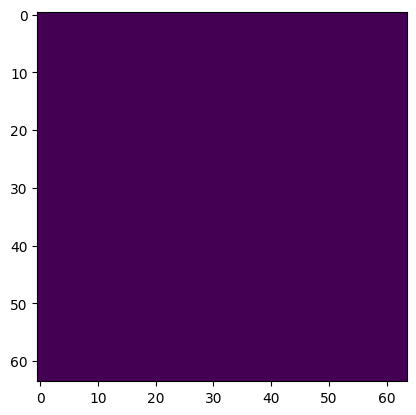

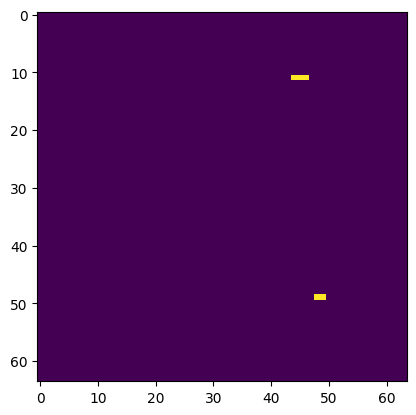

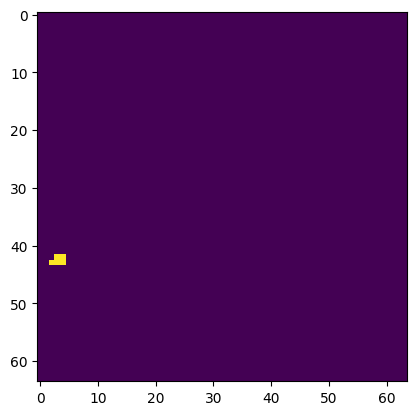

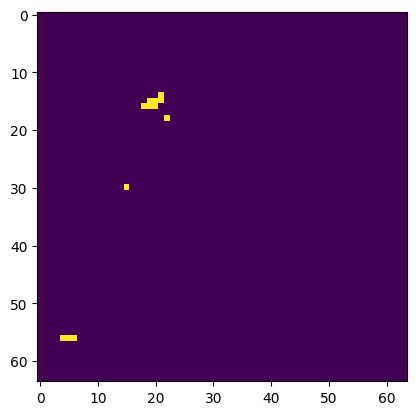

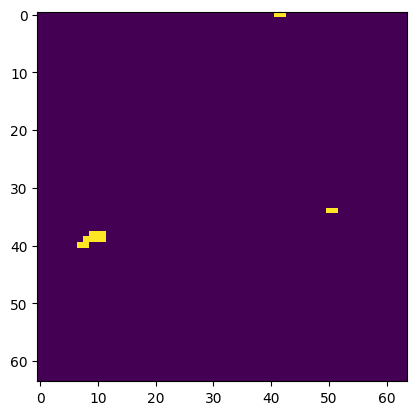

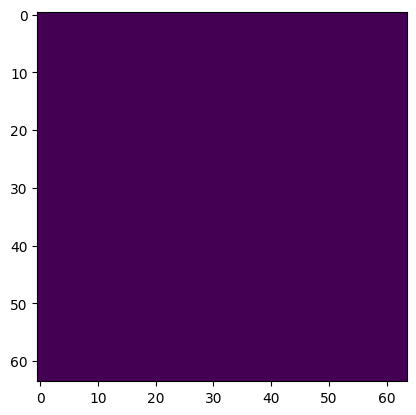

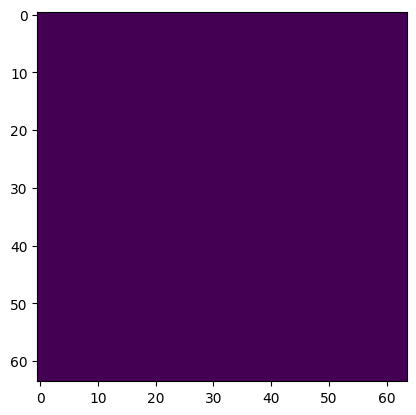

In [ ]:
for i in range(0,10):
  plt.subplots()
  plt.imshow(Y_train[i])

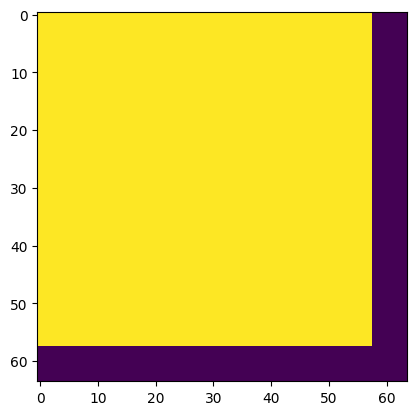

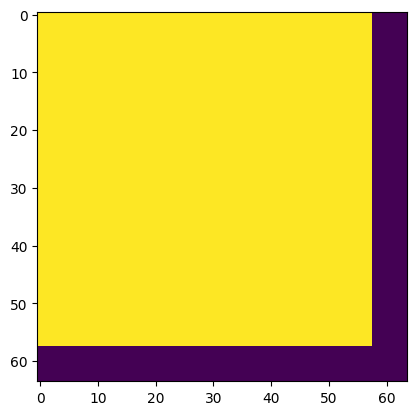

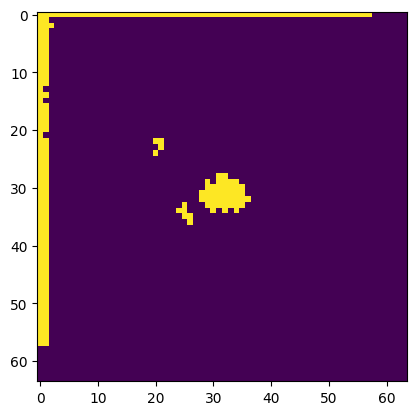

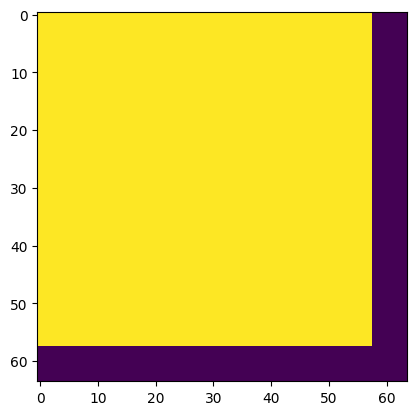

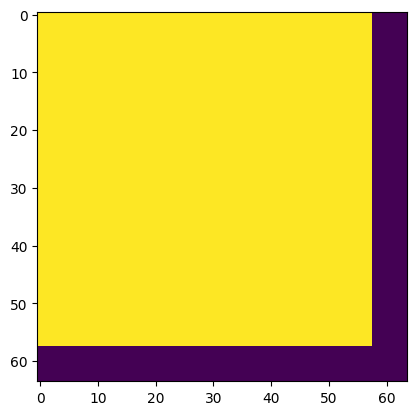

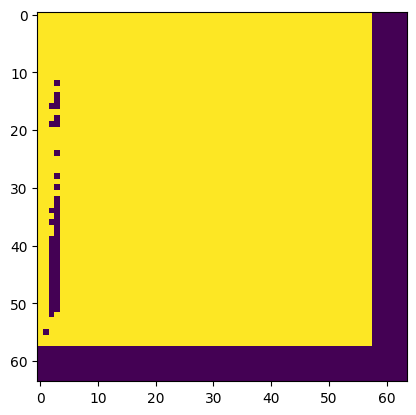

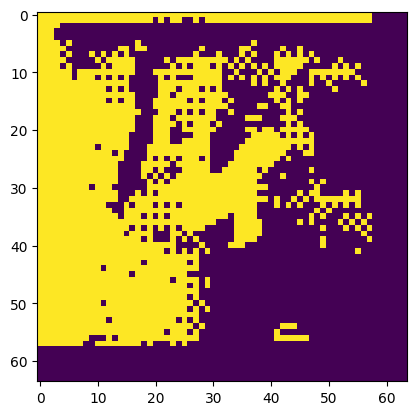

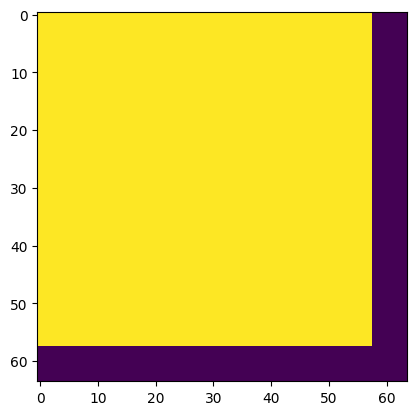

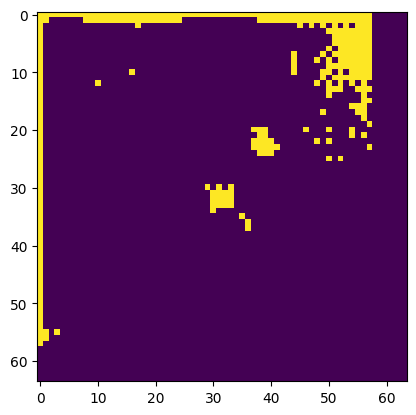

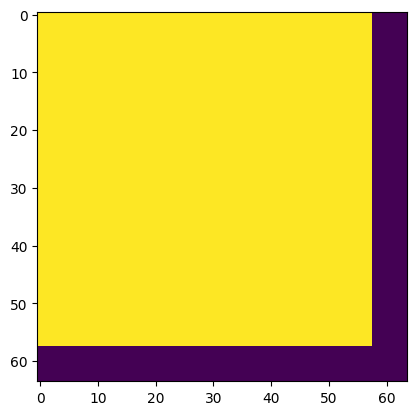

In [ ]:
test = np.zeros([64,64])
for index in range(10):
  plt.subplots()
  for i in range(58):
    for j in range(58):
      if y_pred[index,i,j] < .2:
        test[i,j] = 0
      else:
        test[i,j] = 1
  plt.imshow(test)

(64, 64, 1)


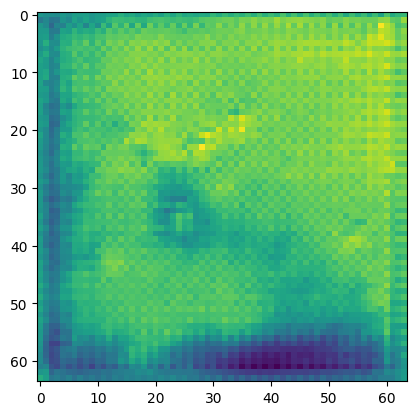

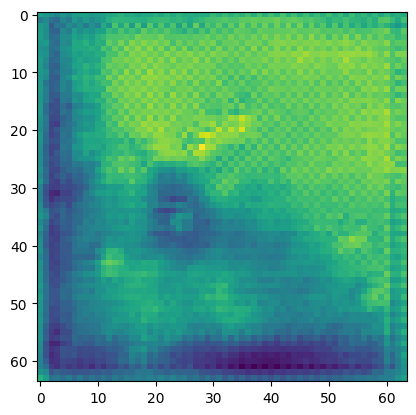

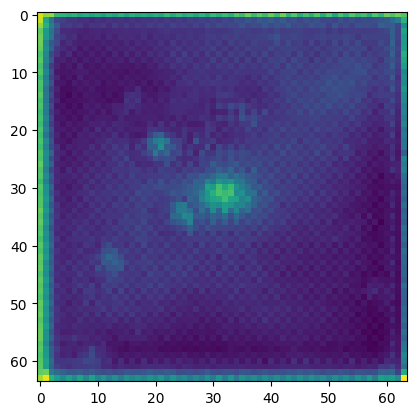

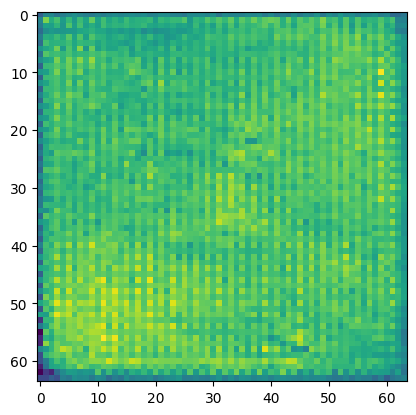

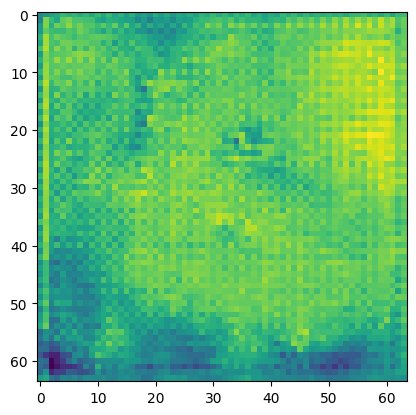

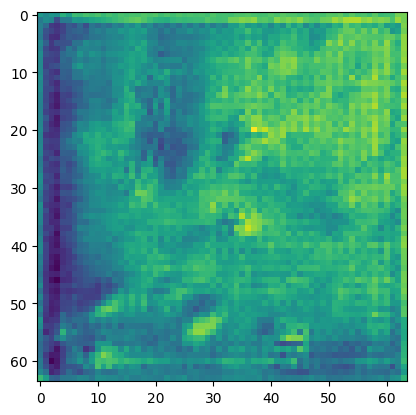

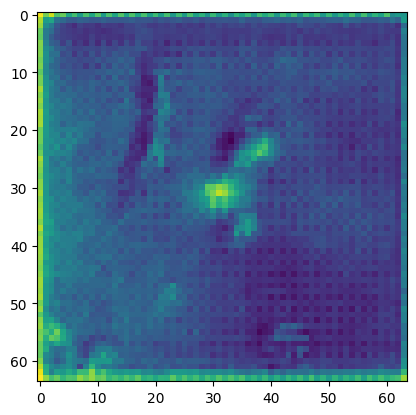

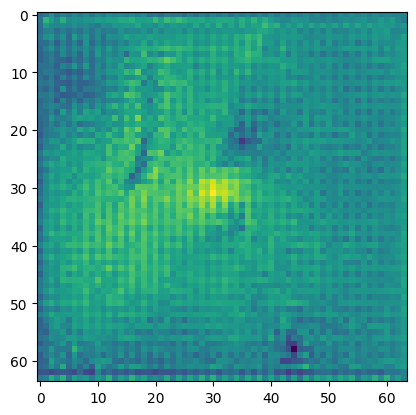

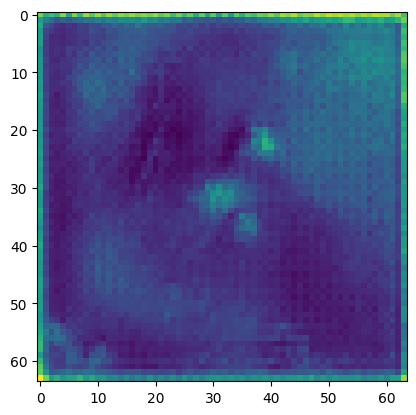

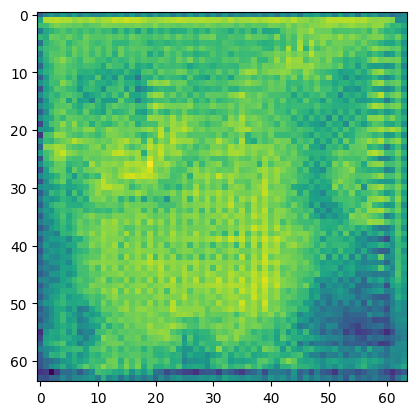

In [ ]:
for i in range(10):
  plt.subplots()

  plt.imshow((y_pred[i]))


print(y_pred[1].shape)

In [ ]:
y_pred[1].mean()

0.44193608

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        print(guidedGrads.shape)

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        # print(weights.shape)
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        heatmap = heatmap.astype(np.float64)
        print(heatmap.shape)
        print(heatmap.dtype)
        image = cv2.merge((image,image,image))
        print(image.shape)
        print(image.dtype)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    print(class_channel.shape)
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = heatmap[0]

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)

        heatmap = heatmap.astype(np.float64)
        # print(heatmap.shape)
        image = cv2.merge((image,image,image))
        # print(image.shape)
        print(image.dtype)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
print(model.get_layer(len(model.layers)-1).name)


ValueError: ignored

In [ ]:
icam = GradCAM(model, i, 'conv2d_57')
heatmap = icam.compute_heatmap(X_norm)

print(heatmap.shape)
image = X_norm[0,:,:,1].squeeze()

# print(image.shape)
# print(type(heatmap), type(image)),
# print(heatmap)
print(image)
(heatmap_elevation, output_elevation) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(64, 64, 16)
(64, 64)
[[0.67443287 0.67414892 0.67396379 ... 0.64507562 0.64385414 0.64260775]
 [0.6756075  0.67519933 0.6748805  ... 0.64218527 0.64101416 0.6398223 ]
 [0.67681807 0.67629313 0.67584842 ... 0.63957763 0.63845432 0.63731414]
 ...
 [0.73343253 0.73424757 0.73512375 ... 0.66449672 0.66296804 0.66150993]
 [0.73344648 0.73430163 0.73521823 ... 0.66540647 0.66383976 0.66234118]
 [0.73342204 0.73431766 0.73527533 ... 0.66637582 0.66477549 0.66324103]]
(64, 64, 3)
float64
(64, 64, 3)
float64


In [ ]:
heatmap_elevation = np.array(heatmap_elevation, dtype='int')

In [ ]:
heatmap_elevation.min()

1

In [ ]:
heatmap_elevation

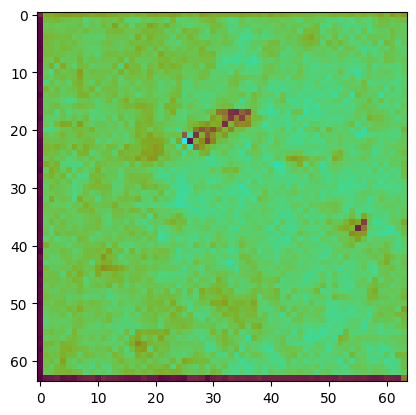

In [ ]:
imgplot = plt.imshow(heatmap_elevation)

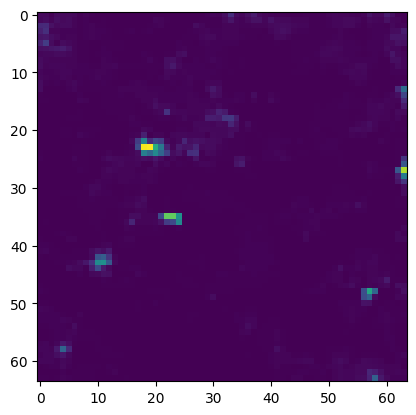

In [ ]:
plt.imshow(X_train[1,:,:,9])

In [ ]:
X_norm = np.zeros((20, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
for i, row in train_data.iterrows():
  if i==20:
    break
  features = np.stack( (row['elevation'], row['th'], row['vs'], row['tmmn'], row['tmmx'], row['sph'], row['pr'], row['pdsi'], row['NDVI'], row['population'], row['erc'], row['PrevFireMask']), axis=2 )
  # for index in range(11):
  #   features[:,:,index] = (features[:,:,index] - averages[index]) / stds[index]
  X_norm[i] = features
  # for j in range(64):
  #   for k in range(64):
  #     if X_norm[i,j,k,11] != 255.0:
  #       X_norm[i,j,k,11] = 0

In [ ]:
X_norm

array([[[[3.60784322e-01, 6.74432874e-01, 1.21280421e-02, ...,
          7.71578997e-02, 8.42806622e-02, 0.00000000e+00],
         [3.21568638e-01, 6.74148917e-01, 1.21260630e-02, ...,
          7.37211481e-02, 8.36449116e-02, 0.00000000e+00],
         [3.52941185e-01, 6.73963785e-01, 1.21260546e-02, ...,
          1.85351893e-02, 8.30023885e-02, 0.00000000e+00],
         ...,
         [2.90196091e-01, 6.45075619e-01, 1.29665555e-02, ...,
          1.04717061e-01, 8.71186480e-02, 0.00000000e+00],
         [2.74509817e-01, 6.43854141e-01, 1.29494714e-02, ...,
          8.39866977e-03, 8.72289240e-02, 0.00000000e+00],
         [2.66666681e-01, 6.42607749e-01, 1.29308356e-02, ...,
          5.00668352e-03, 8.73290226e-02, 0.00000000e+00]],

        [[3.80392164e-01, 6.75607502e-01, 1.21338051e-02, ...,
          6.72462583e-02, 8.41240957e-02, 0.00000000e+00],
         [3.76470596e-01, 6.75199330e-01, 1.21299317e-02, ...,
          1.00230619e-01, 8.34671035e-02, 0.00000000e+00],
        

In [ ]:
for i in range(12):
  min = X_norm[:,:,:,i].min()
  range = X_norm[:,:,:,i].max() - min
  X_norm[:,:,:,i] = 255 * (X_norm[:,:,:,i] - min)/range

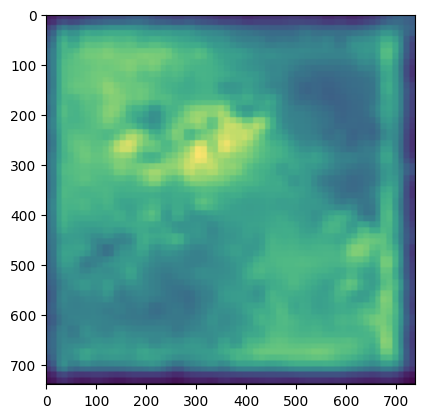

In [ ]:
img = cv2.imread("/content/Screenshot 2023-04-19 at 9.40.10 PM.png")
plt.imshow(img,)

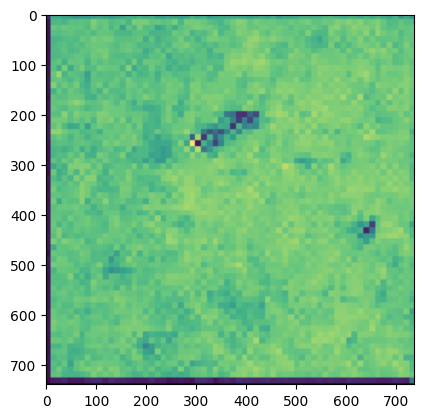

In [ ]:
image = cv2.imread('/content/Screenshot 2023-04-21 at 1.23.13 PM.png')
plt.imshow(image, cmap='cividis')

# Old stuff

In [ ]:


import tensorflow as tf
import matplotlib.pyplot as plt

# Define a function to parse each example in the dataset
def _parse_function(example_proto):

    # Define the features to parse
    feature_description = {
        'todays_frp': tf.io.FixedLenFeature([], tf.string),
        'landcover': tf.io.FixedLenFeature([], tf.string),
        'air_temperature_at_2_metres_1hour_Minimum': tf.io.FixedLenFeature([], tf.string),
        'air_temperature_at_2_metres_1hour_Maximum': tf.io.FixedLenFeature([], tf.string),
        'todays_fires': tf.io.FixedLenFeature([], tf.string),
        'tomorrows_fires': tf.io.FixedLenFeature([], tf.string),
        'elevation': tf.io.FixedLenFeature([], tf.string),
        'ndvi': tf.io.FixedLenFeature([], tf.string),
    }
    # Parse the example
    example = tf.io.parse_single_example(example_proto, feature_description)
    # Decode the image
    todays_frp = tf.image.decode_jpeg(example['todays_frp'], channels=3,)
    todays_frp = tf.cast(todays_frp, tf.float32) / 255.0
    landcover = tf.image.decode_jpeg(example['landcover'], channels=3)
    landcover = tf.cast(landcover, tf.float32) / 255.0
    air_temp_min = tf.image.decode_jpeg(example['air_temperature_at_2_metres_1hour_Minimum'], channels=3)
    air_temp_min = tf.cast(air_temp_min, tf.float32) / 255.0
    air_temp_max = tf.image.decode_jpeg(example['air_temperature_at_2_metres_1hour_Maximum'], channels=3)
    air_temp_max = tf.cast(air_temp_max, tf.float32) / 255.0
    todays_fires = tf.image.decode_jpeg(example['todays_fires'], channels=3)
    todays_fires = tf.cast(todays_fires, tf.float32) / 255.0
    tomorrows_fires = tf.image.decode_jpeg(example['tomorrows_fires'], channels=3)
    tomorrows_fires = tf.cast(tomorrows_fires, tf.float32) / 255.0
    elevation = tf.image.decode_jpeg(example['elevation'], channels=3)
    elevation = tf.cast(elevation, tf.float32) / 255.0
    ndvi = tf.image.decode_jpeg(example['ndvi'], channels=3)
    ndvi = tf.cast(ndvi, tf.float32) / 255.0

    return todays_frp, landcover, air_temp_min, air_temp_max, todays_fires, tomorrows_fires, elevation, ndvi

# Map the parsing function onto the dataset
parsed_dataset = raw_dataset.map(_parse_function)

# Iterate over the dataset and display the images
for todays_frp, landcover, air_temp_min, air_temperature_at_2_metres_1hour_Maximum, todays_fires, tomorrows_fires, elevation, ndvi in parsed_dataset.take(10):
    print('todays_frp={}, landcover={}, air_temp_min={}, air_temp_max={}, todays_fires={}, tomorrows_fires={}, elevation={}, ndvi={}'.format(todays_frp, landcover, air_temp_min, air_temp_max, todays_fires, tomorrows_fires, elevation, ndvi))

# for todays_fires, tomorrows_fires in parsed_dattaset.take(10):

In [ ]:
import pandas as pd
import pandas_tfrecords as pdtfr
df = pdtfr.tfrecords_to_pandas(file_paths=r'/content/tfrecords_updated_filtered/sv_10112_10240.tfrecords')

In [ ]:
def parse_df_element(element):
    parser = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'age': tf.io.FixedLenFeature([], tf.int64),
        'sex': tf.io.FixedLenFeature([], tf.int64),
    }
    # create an example:
    content = tf.io.parse_single_example(element, parser)
    return content['name'], \
        content['age'], content['sex']

In [ ]:
parsed_tf_records = dataset.map(parse_ac_element)
df = pd.DataFrame(
    parsed_tf_records.as_numpy_iterator(),
    columns=['todays_frp', 'landcover', 'air_temperature_at_2_metres_1hour_Minimum', 'air_temperature_at_2_metres_1hour_Maximum', 'todays_fires', 'tomorrows_fires', 'ndvi', 'elevation']
)

In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Add the convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Add the flatten layer
model.add(layers.Flatten())

# Add the fully connected layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add the output layer
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf

# Define the neural network architecture
model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the evaluation metric
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(X_train, Y_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Pretrained

In [ ]:
!pip3 install -U pip
!pip3 install -U setuptools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-wsf39fko
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-wsf39fko
  Resolved https://github.com/tensorflow/examples.git to commit 5bc9f1ed519146242db5e71f00d9d39d52a308c8
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[64, 64, 11], include_top=False)

# Use the activations of these layers
layer_names = [
    # 'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    # pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

NameError: ignored

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[64, 64, 11])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 1

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))